In [ ]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tfds-nightly
!pip install matplotlib
!pip install PIL

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfdf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/MyDrive/Indian Medicinal Leaves Image Datasets.zip"

# **for Distribution of learning amont two gpus, T4x2****

In [2]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

# **Importing dataset****
BATCH_SIZE is 32 for 1 gpu,

In [3]:
BATCH_SIZE = 32
batch_size_ = BATCH_SIZE * mirrored_strategy.num_replicas_in_sync
img_height = 224
img_width = 224
CHANNEL = 3
data_dir = r"/kaggle/input/indian-medicinal-leaves-dataset/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset"
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size_)

Found 6900 files belonging to 80 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']


# **Plotting Images for Visualization****

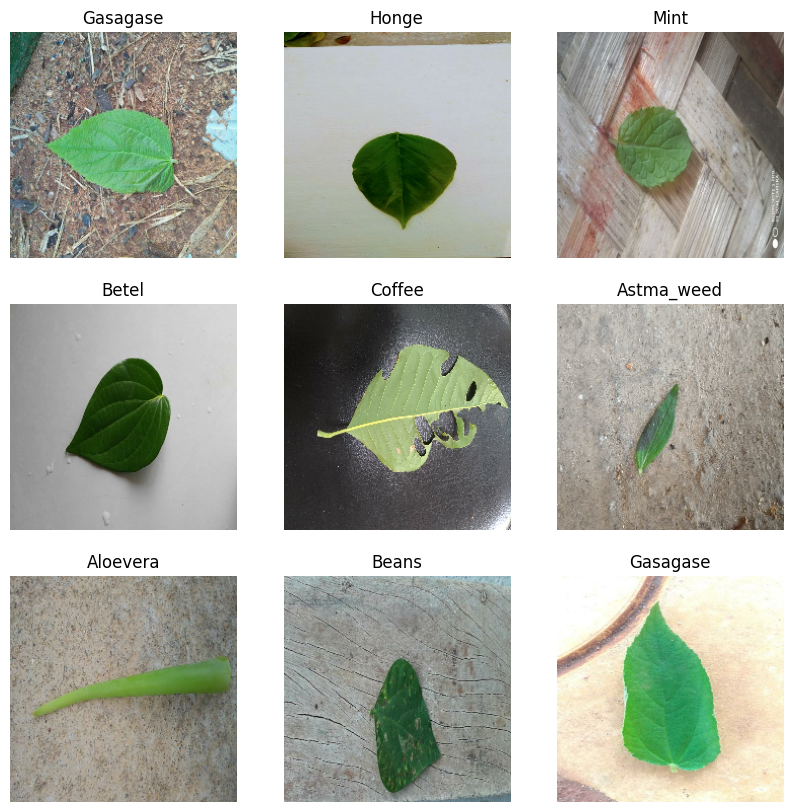

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Train Test Split****

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [9]:
# resizing images layer, later will be added in the model
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_height),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# **Augmentation****

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
# from tensorflow.keras.applications import VGG16,VGG19, Xception, ResNet50, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet121, NASNetLarge, EfficientNetB0

# feature_extractor = VGG19(input_shape=(224, 224, 3),
#                                 include_top=False,
#                                 weights="imagenet",
#                                 pooling = 'avg',
#                                 classifier_activation='softmax',
#                                 classes=80)

# import tensorflow_hub as hub
# model_url = '/kaggle/input/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b0-feature-vector/1'
# efficientnet_v2_s = hub.KerasLayer(model_url, trainable=True, name='efficientnet_v2_s')


In [13]:
# for layer in feature_extractor.layers:
#     layer.trainable=False

# **Code below is commented,it is for the learning rate, can be used for some experimentation****

In [ ]:
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

# total_epochs = 100
# initial_learning_rate = 5e-3
# decay_rate = 0.9

# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=total_epochs // 10,
#     decay_rate=decay_rate,
#     staircase=True
# )




In [ ]:

# epochs = np.arange(1, total_epochs + 1)
# learning_rates = [lr_schedule(epoch) for epoch in epochs]


# plt.plot(epochs, learning_rates, label='Learning Rate')
# plt.title('Exponential Learning Rate Schedule')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.show()



# **Importing Model for Transfer Learning****

**(i have already tried multiple models, other that this what worked best for me are, Inceptionv3, mobilenet, mobilenetv2, vgg16, vgg19)****

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models
# from kerastuner.tuners import Hyperband
import tensorflow_hub as hub
model_url = '/kaggle/input/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b0-feature-vector/1'

with mirrored_strategy.scope():
    efficientnet_v2_s = hub.KerasLayer(model_url, trainable=False, name='efficientnet_v2_s')
    model = Sequential([
        resize_and_rescale,
        efficientnet_v2_s,
        layers.Dropout(0.3),
        layers.Dense(80, activation='softmax')
    ])


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0007),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


# **plot model architecture****

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=800)

# **callback for earlystopping(really helpful for saving time and preventing the model from overfitting)****

In [38]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 8,
                              verbose = 1)


callback_list = [earlystopping]

In [39]:
model_history=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
75/75 [==============================] - 70s 788ms/step - loss: 3.5898 - accuracy: 0.1788 - val_loss: 2.1400 - val_accuracy: 0.5088
Epoch 2/100
75/75 [==============================] - 54s 721ms/step - loss: 1.9709 - accuracy: 0.5086 - val_loss: 1.3490 - val_accuracy: 0.7061
Epoch 3/100
75/75 [==============================] - 58s 776ms/step - loss: 1.3894 - accuracy: 0.6631 - val_loss: 1.0270 - val_accuracy: 0.7939
Epoch 4/100
75/75 [==============================] - 59s 782ms/step - loss: 1.0988 - accuracy: 0.7281 - val_loss: 0.8152 - val_accuracy: 0.8281
Epoch 5/100
75/75 [==============================] - 57s 758ms/step - loss: 0.9296 - accuracy: 0.7767 - val_loss: 0.7023 - val_accuracy: 0.8467
Epoch 6/100
75/75 [==============================] - 57s 753ms/step - loss: 0.7894 - accuracy: 0.8112 - val_loss: 0.6362 - val_accuracy: 0.8467
Epoch 7/100
75/75 [==============================] - 57s 761ms/step - loss: 0.6992 - accuracy: 0.8292 - val_loss: 0.5566 - val_accuracy:

In [40]:
# save model
model.save("efficientnet_v2_extractor_2.keras")

# **Here i have tried to get better accuracy by compiling the model with smaller learning rate
# It worked, since i got a test accuracy from 94.5 to 96.5, in my model extractor_2****

In [58]:
# from tensorflow.keras.models import Model, load_model
# with mirrored_strategy.scope():
#     model = load_model("/kaggle/working/efficientnet_v2_extractor_2.keras")
#     model.compile(
#             optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#             metrics=['accuracy']
#         )
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

with mirrored_strategy.scope():
    custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model with the custom_objects parameter
    model = load_model("/kaggle/working/efficientnet_v2_extractor_2.keras", custom_objects=custom_objects)


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


In [59]:
model_history_1=model.fit(train_ds,
                        validation_data=val_ds,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
75/75 [==============================] - 68s 767ms/step - loss: 0.1717 - accuracy: 0.9614 - val_loss: 0.2053 - val_accuracy: 0.9404
Epoch 2/100
75/75 [==============================] - 58s 767ms/step - loss: 0.1690 - accuracy: 0.9630 - val_loss: 0.2019 - val_accuracy: 0.9414
Epoch 3/100
75/75 [==============================] - 57s 762ms/step - loss: 0.1614 - accuracy: 0.9649 - val_loss: 0.1966 - val_accuracy: 0.9434
Epoch 4/100
75/75 [==============================] - 57s 757ms/step - loss: 0.1671 - accuracy: 0.9645 - val_loss: 0.1991 - val_accuracy: 0.9443
Epoch 5/100
75/75 [==============================] - 57s 754ms/step - loss: 0.1653 - accuracy: 0.9643 - val_loss: 0.1989 - val_accuracy: 0.9443
Epoch 6/100
75/75 [==============================] - 58s 768ms/step - loss: 0.1721 - accuracy: 0.9643 - val_loss: 0.1996 - val_accuracy: 0.9434
Epoch 7/100
75/75 [==============================] - 56s 749ms/step - loss: 0.1861 - accuracy: 0.9574 - val_loss: 0.1985 - val_accuracy:

# **tried this model but already got better accuracy in the previous one****

In [60]:
model.save("efficientnet_v2_extractor_2_8.keras")

# **efficientnet_v2_extractor_2_5 was better, learning rate I used is 0.0001****



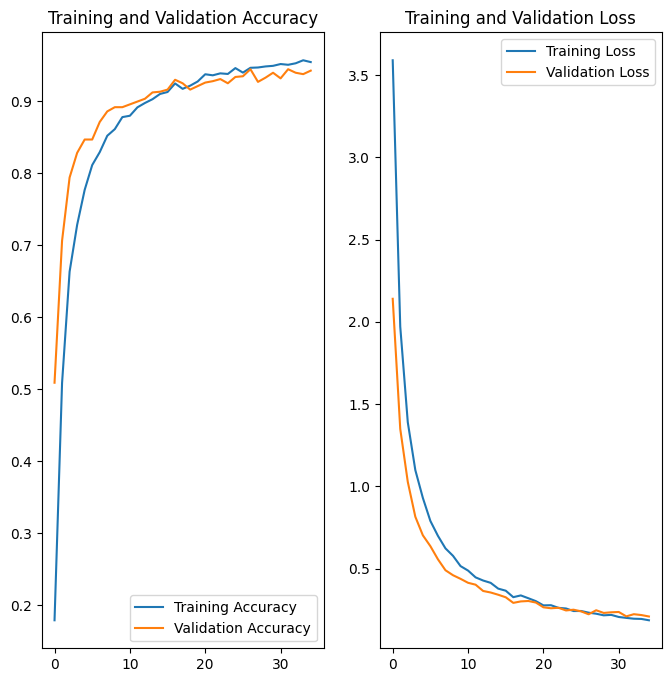

In [41]:
# extractor_2 loss and accuracy graph
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
with mirrored_strategy.scope():
    custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model with the custom_objects parameter
    model = load_model("/kaggle/working/efficientnet_v2_extractor_2_5.keras", custom_objects=custom_objects)

# **evaluating the model on test data****

In [64]:
model.evaluate(test_ds)

17/17 [==============================] - 5s 74ms/step - loss: 0.1466 - accuracy: 0.9660


[0.14657340943813324, 0.9659926295280457]

# **Evaluation metrics - classification Report, precision, recall, f1 score etc., to evaluate the model performance**** 

In [65]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

# Function to predict a single image
def predict(model, image):
    predictions = model.predict(np.expand_dims(image, axis=0), verbose=0)

    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    return predicted_class, confidence

In [66]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    for i in range(len(labels)):
        true_labels.append(labels[i].numpy())

        predicted_class, _ = predict(model, images[i].numpy())
        predicted_labels.append(predicted_class)

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


In [67]:
# cm = confusion_matrix(true_labels, predicted_labels)
# plt.figure(figsize=(8, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

In [68]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9708
Recall: 0.9660
F1 Score: 0.9666


first image to predict
actual label: Malabar_Nut
2/2 [==============================] - 1s 31ms/step
predicted label: Malabar_Nut


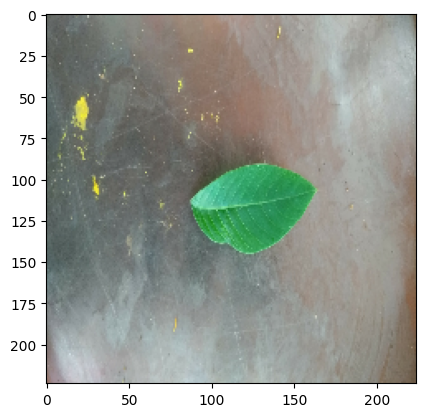

In [69]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [70]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose = 0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

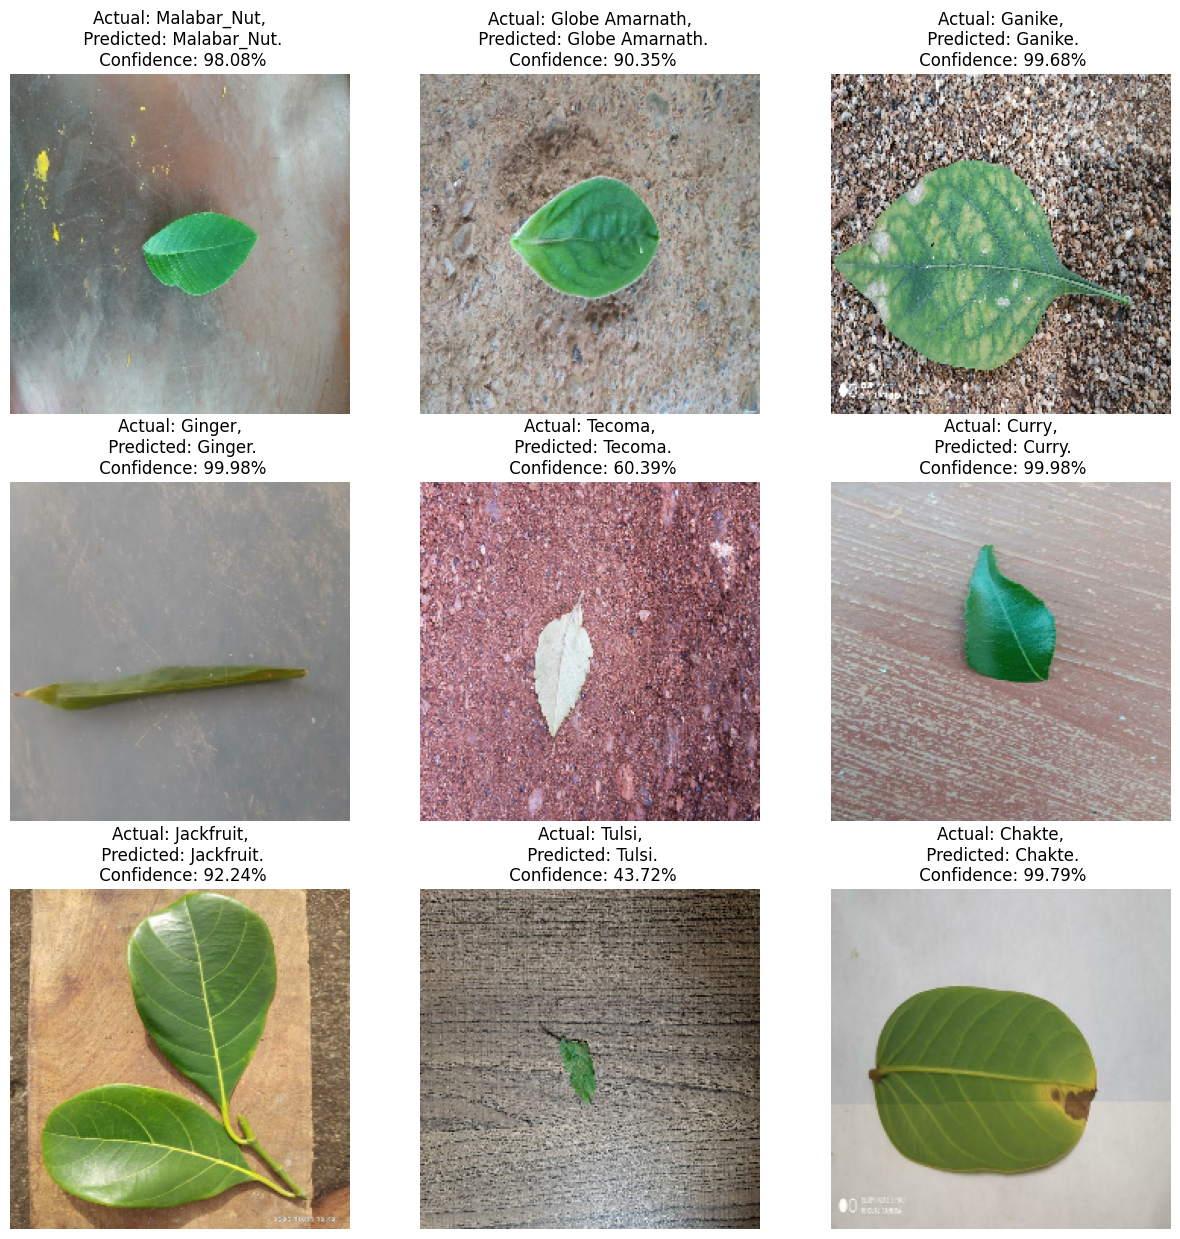

In [71]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [92]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable

report = classification_report(true_labels, predicted_labels)
# print("Classification Report:\n", report)
table = PrettyTable()
table.field_names = ["Classification Report", "Class Names"]

table.add_row([report, '\n'.join(f"{i}: {class_name}" for i, class_name in enumerate(class_names))])

table.align["Classification Report"] = "l"
table.align["Class Names"] = "l"

print(table)






+-------------------------------------------------------+-----------------------------+
| Classification Report                                 | Class Names                 |
+-------------------------------------------------------+-----------------------------+
|               precision    recall  f1-score   support | 0: Aloevera                 |
|                                                       | 1: Amla                     |
|            0       1.00      0.94      0.97        16 | 2: Amruthaballi             |
|            1       1.00      0.80      0.89         5 | 3: Arali                    |
|            2       1.00      1.00      1.00        19 | 4: Astma_weed               |
|            3       1.00      1.00      1.00        20 | 5: Badipala                 |
|            4       1.00      0.94      0.97        17 | 6: Balloon_Vine             |
|            5       0.90      0.90      0.90        10 | 7: Bamboo                   |
|            6       1.00      0

# **Top missclassification**** 

In [80]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Set diagonal elements (correct predictions) to 0
np.fill_diagonal(conf_matrix, 0)

# Find the indices of top N misclassifications
N = 5
top_misclassifications = np.argsort(-conf_matrix.flatten())[:N]

# Convert flat indices to row and column indices
top_misclass_rows, top_misclass_cols = np.unravel_index(top_misclassifications, conf_matrix.shape)

# Print the top N misclassifications
for i in range(N):
    true_class = class_names[top_misclass_rows[i]]
    predicted_class = class_names[top_misclass_cols[i]]
    count = conf_matrix[top_misclass_rows[i], top_misclass_cols[i]]
    print(f"True class: {true_class}, Predicted class: {predicted_class}, Count: {count}")


True class: Neem, Predicted class: Nelavembu, Count: 2
True class: Curry, Predicted class: Sapota, Count: 2
True class: Thumbe, Predicted class: Sapota, Count: 2
True class: Rose, Predicted class: Nerale, Count: 1
True class: Citron lime (herelikai), Predicted class: Sapota, Count: 1


# **Testing on my own images****

In [ ]:
import cv2
img_path = r""
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
resized_img = tf.image.resize(img, (224,224))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [ ]:
yhat=model.predict(np.expand_dims(resized_img/255, 0))
print(yhat)

In [ ]:
print(np.argmax(yhat))
predicted_label = class_names[np.argmax(yhat)]
print(predicted_label)